# Example with Dogs

#### importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image

from tqdm import tqdm_notebook as tqdm

import gdown
import zipfile

#### Downloading data from G-Drive and uzipping the downloaded data

In [2]:
id = "1Ub7Nf8bCU0nL9igbl2UqXVsJL18zKqjD"
output = "data.zip"
path = "./data.zip"
if not os.path.exists(path):
  gdown.download(id=id, output=output, quiet=False)
  with zipfile.ZipFile(output, "r") as zip:
    zip.extractall("./")
    path = zip.namelist()[0]

Downloading...
From: https://drive.google.com/uc?id=1Ub7Nf8bCU0nL9igbl2UqXVsJL18zKqjD
To: /content/data.zip
100%|██████████| 72.4M/72.4M [00:01<00:00, 45.5MB/s]


#### Setting the batch size and assigning the appropriate device

In [3]:
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Custom dataset

In [4]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):

        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2

        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))

            if self.transform1 is not None:
                img = self.transform1(img)

            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]

        if self.transform2 is not None:
            img = self.transform2(img)

        return img

    def __len__(self):
        return len(self.imgs)

In [5]:
# First preprocessing of data
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=10)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = DogDataset(img_dir = f"./{path}",
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

### Examples of data

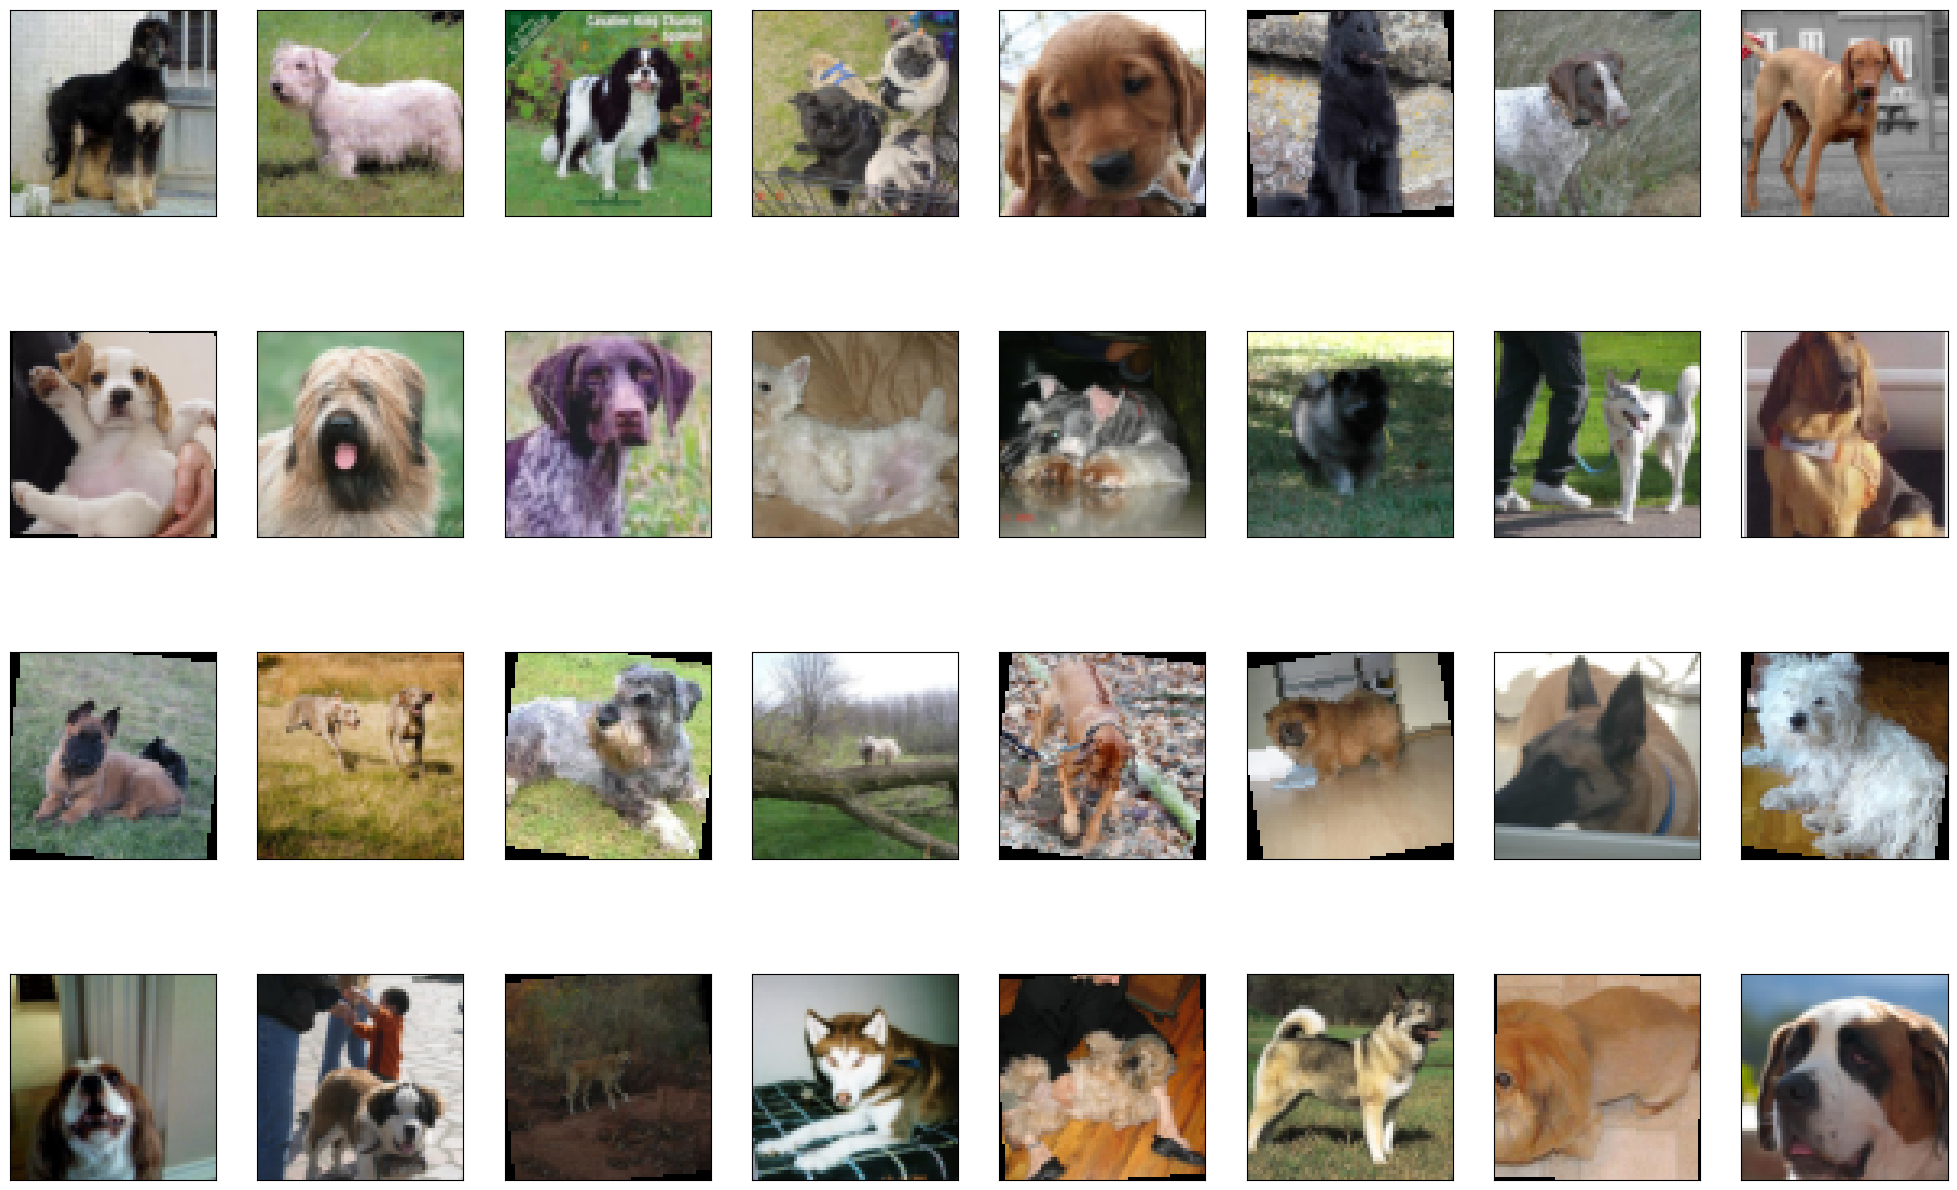

In [6]:
x = next(iter(train_loader))

fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(x):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])

    img = img.numpy().transpose(1, 2, 0)
    plt.imshow((img+1.)/2.)

### VAE Model

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128, no_of_sample=10, batch_size=32, channels=3):
        super(VAE, self).__init__()

        self.no_of_sample = no_of_sample
        self.batch_size = batch_size
        self.channels = channels
        self.latent_dim = latent_dim


        # Encoder
        def convlayer_enc(n_input, n_output, k_size=4, stride=2, padding=1, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.encoder = nn.Sequential(
            *convlayer_enc(self.channels, 64, 4, 2, 2),               # (64, 32, 32)
            *convlayer_enc(64, 128, 4, 2, 2),                         # (128, 16, 16)
            *convlayer_enc(128, 256, 4, 2, 2, bn=True),               # (256, 8, 8)
            *convlayer_enc(256, 512, 4, 2, 2, bn=True),               # (512, 4, 4)
            nn.Conv2d(512, self.latent_dim*2, 4, 1, 1, bias=False),   # (latent_dim*2, 4, 4)
            nn.LeakyReLU(0.2, inplace=True)
        )


        # Decoder
        def convlayer_dec(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.decoder = nn.Sequential(
            *convlayer_dec(self.latent_dim, 512, 4, 2, 1),           # (512, 8, 8)
            *convlayer_dec(512, 256, 4, 2, 1),                       # (256, 16, 16)
            *convlayer_dec(256, 128, 4, 2, 1),                       # (128, 32, 32)
            *convlayer_dec(128, 64, 4, 2, 1),                        # (64, 64, 64)
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),          # (3, 64, 64)
            nn.Sigmoid()
        )

    def encode(self, x):
        '''return mu_z and logvar_z'''
        x = self.encoder(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]

    def decode(self, z):
        z = self.decoder(z)
        return z.view(-1, 3 * 64 * 64)

    def reparameterize(self, mu, logvar):
        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation

            sample_z = []
            for _ in range(self.no_of_sample):
                std = logvar.mul(0.5).exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))
            return sample_z

        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 3 * 64 * 64))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 3 * 64 * 64))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= self.batch_size * 3 * 64 * 64

        return BCE + KLD

Input dim is `64 x 64 x 3 = 12288`<br>
Latent dim is `4 x 4 x 32 = 512`<br>
Bottleneck is 24 times smaller than input image! Autoencoder should keep most important information

In [8]:
lr = 0.001
epochs = 50
latent_dim = 32

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

#### Image for validation

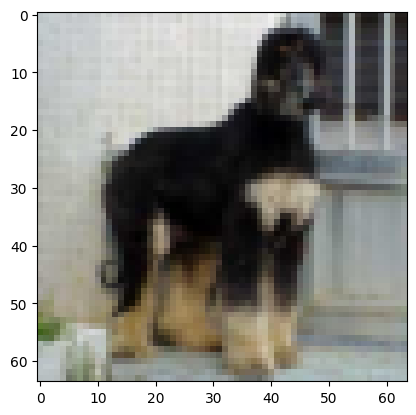

In [9]:
plt.imshow((x[0].numpy().transpose(1, 2, 0)+1)/2)
plt.show()

### Train loop

Epoch 1 start


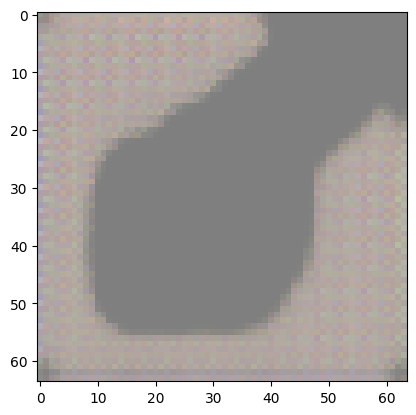

Epoch 2 start


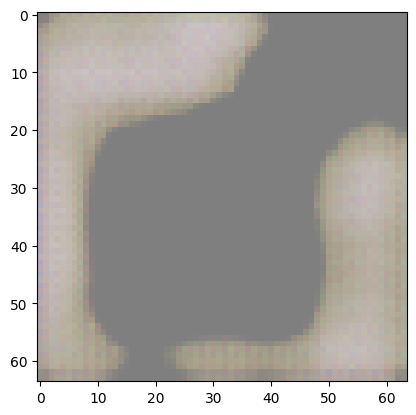

Epoch 3 start


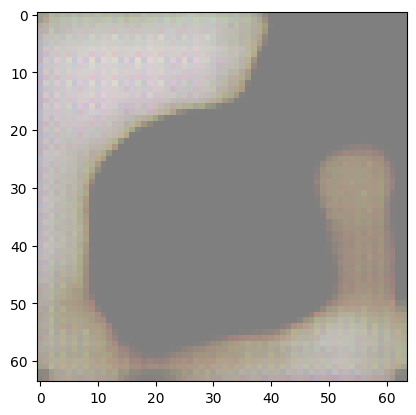

Epoch 4 start


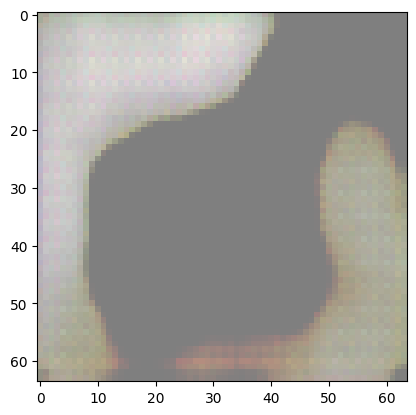

Epoch 5 start


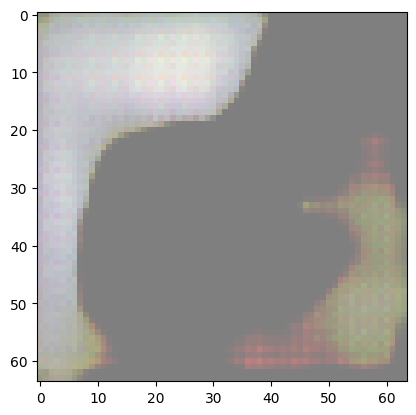

Epoch 6 start


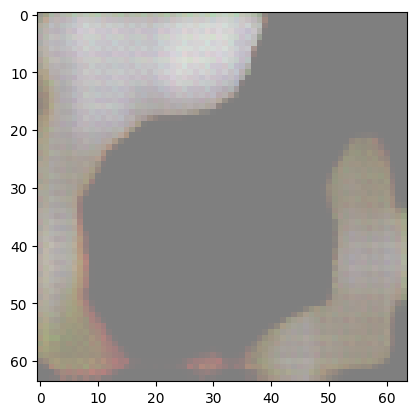

Epoch 7 start


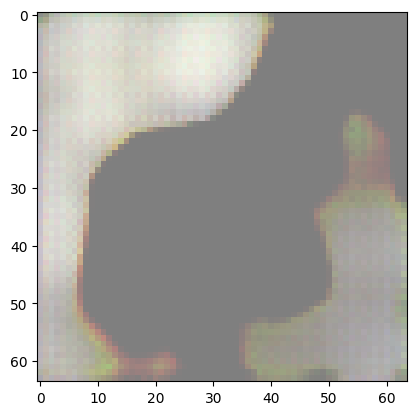

Epoch 8 start


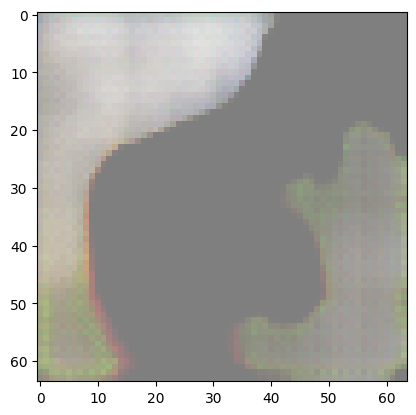

Epoch 9 start


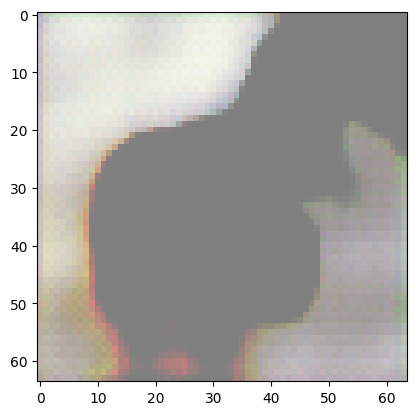

Epoch 10 start


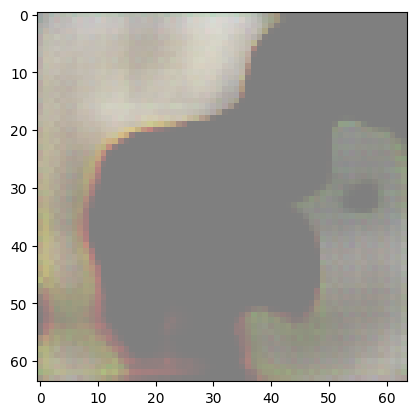

Epoch 11 start


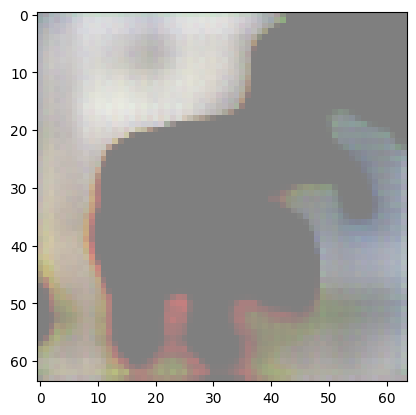

Epoch 12 start


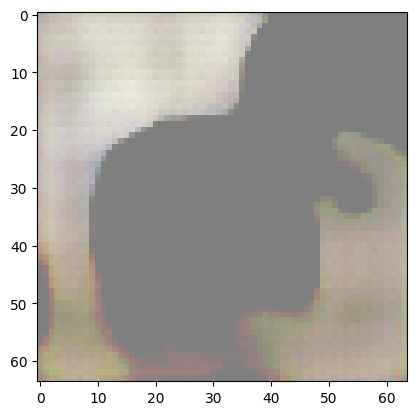

Epoch 13 start


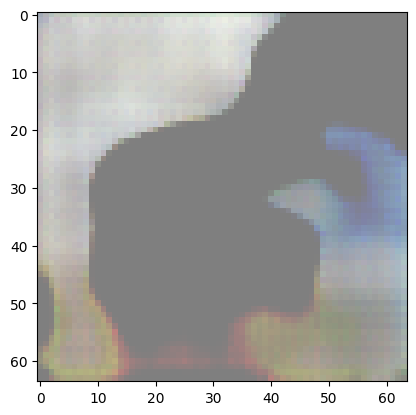

Epoch 14 start


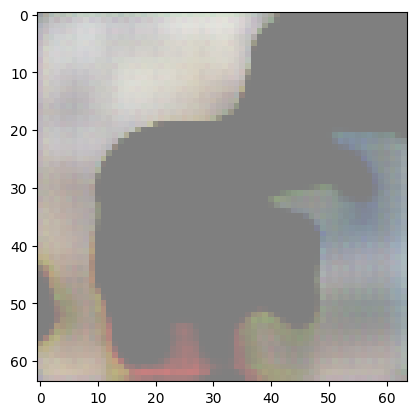

Epoch 15 start


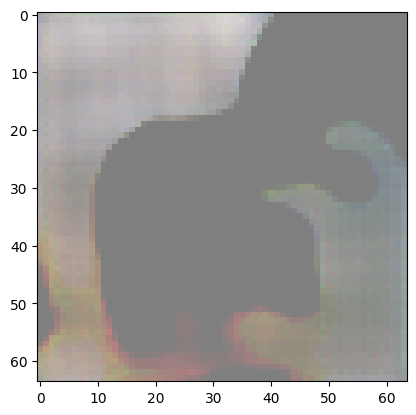

Epoch 16 start


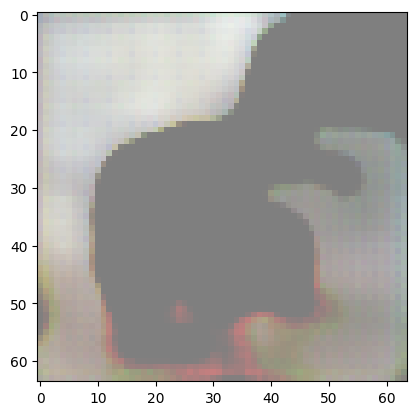

Epoch 17 start


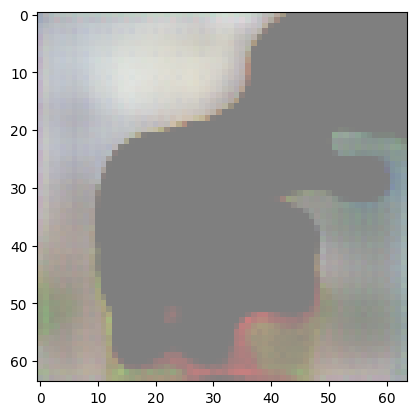

Epoch 18 start


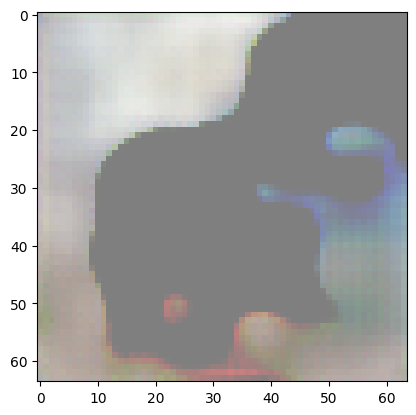

Epoch 19 start


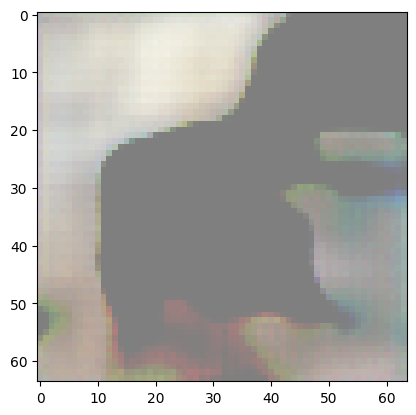

Epoch 20 start


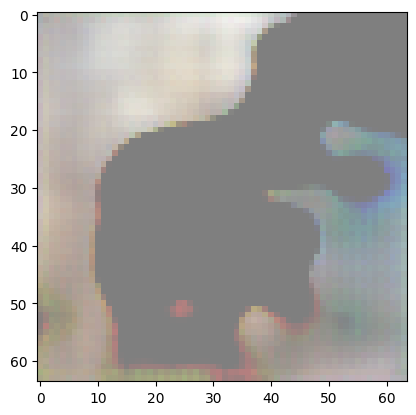

Epoch 21 start


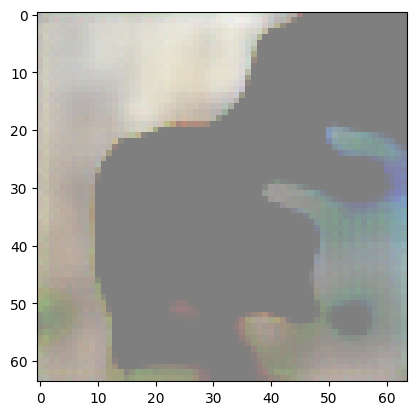

Epoch 22 start


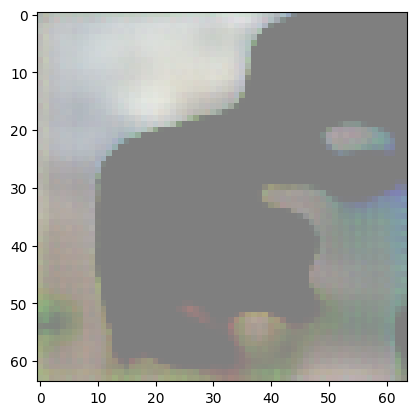

Epoch 23 start


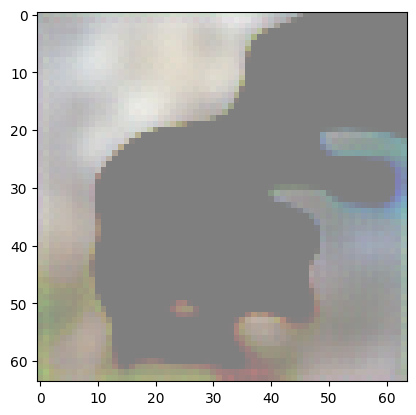

Epoch 24 start


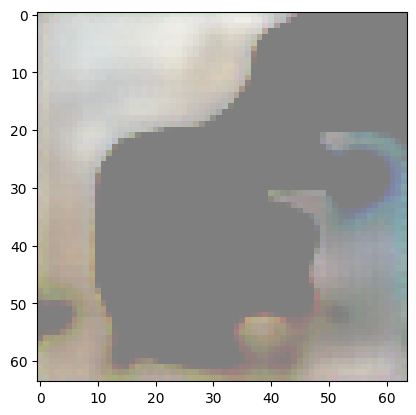

Epoch 25 start


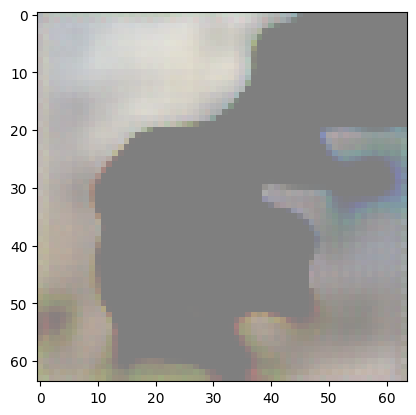

Epoch 26 start


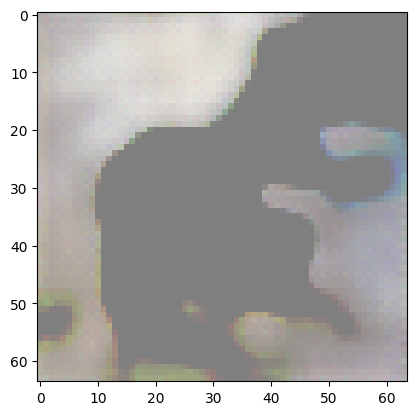

Epoch 27 start


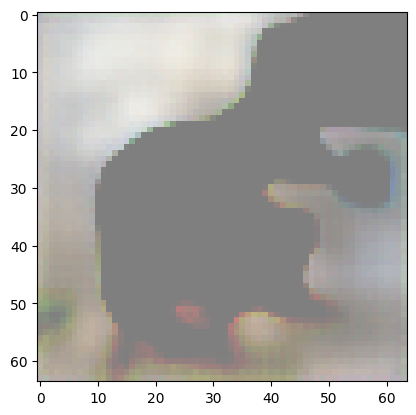

Epoch 28 start


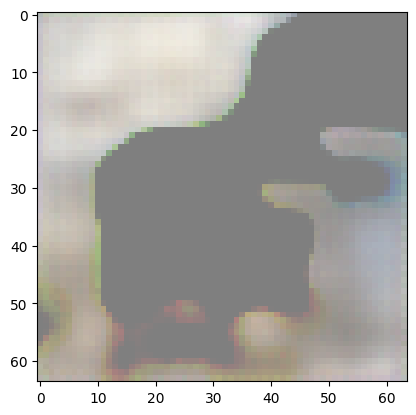

Epoch 29 start


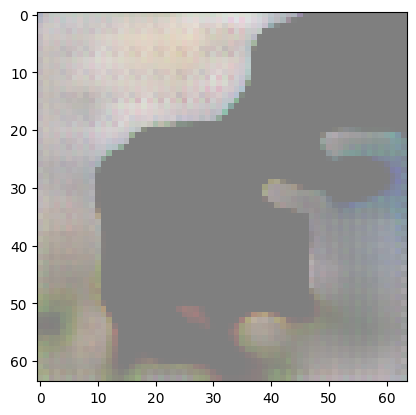

Epoch 30 start


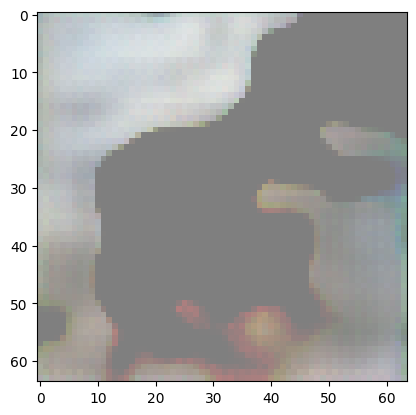

Epoch 31 start


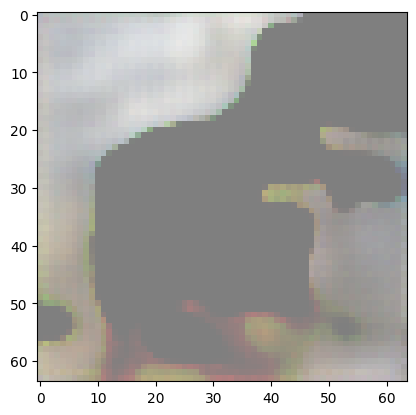

Epoch 32 start


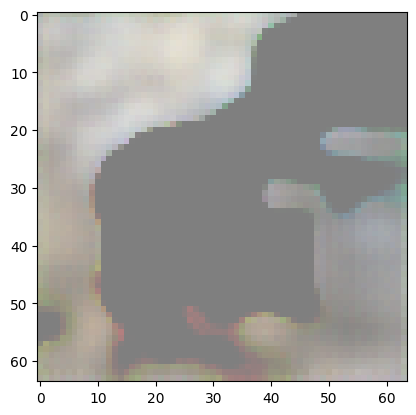

Epoch 33 start


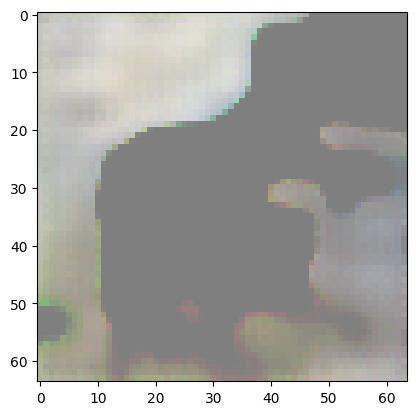

Epoch 34 start


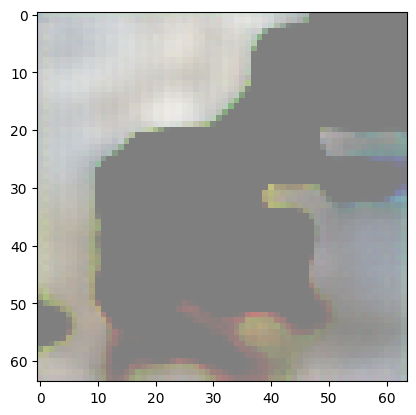

Epoch 35 start


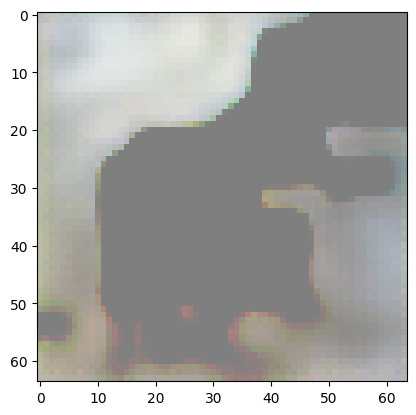

Epoch 36 start


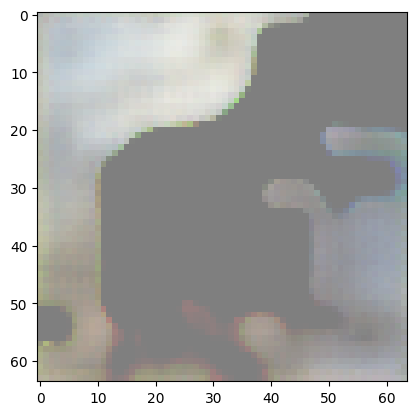

Epoch 37 start


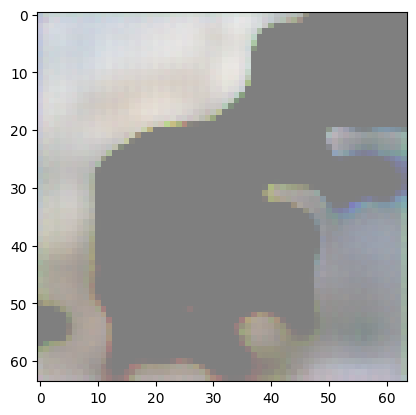

Epoch 38 start


In [ ]:
for epoch in range(1, epochs+1):
    model.train()
    print(f'Epoch {epoch} start')

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()

    model.eval()
    recon_img, _, _ = model(x[:1].to(device))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)

    plt.imshow((img+1.)/2.)
    plt.show()

### Check how well VAE reconstruct images

In [ ]:
reconstructed, mu, _ = model(x.to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

### Walk in latent space from one dog to another

In [ ]:
first_dog_idx = 0
second_dog_idx = 1

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

### Generate random noise and run decoder on this

In [ ]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for i, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)